# Assignment #4 - Reinforcement Learning

<font color="blue"> jawad chowdhury </font>

# I. Overview

<!-- Describe the objective of this assignment. You can briefly state how you accompilsh it. -->

The main objective of this assignment was to implement a modified version of Game Rummy by training an agent with Re-inforcement learning.

Here, i get familiarized with the basic Reinforcement environment including states, actions, rewards etc.

And also got some idea about different approaches such as SAARSA, Q-learning and some related methodologies like epsilon-greedy.

## Rummy Environment

In [2]:
import random 
from functools import reduce
from collections import defaultdict
import numpy as np
from copy import copy
%matplotlib inline

Here, we define the SUITS, RANKS of the cards and their RANK_VALUE.

In [3]:
SUIT = ['H','S','D','C']
RANK = ['A', '2', '3', '4', '5','6','7']
RANK_VALUE = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'Q': 10, 'K': 10}

## Card Class Definition
<!-- __init__  : Defines the card details such as rank, suit and calculates the rank value -->


In [4]:
class Card:
    def __init__(self, rank, suit):
        self.rank = rank
        self.suit = suit
        self.rank_to_val = RANK_VALUE[self.rank]

    def __str__(self):
        return f'{self.rank}{self.suit}'

    def __repr__(self):
        return f'{self.rank}{self.suit}'

    def __eq__(self, other):
        return self.rank == other.rank and self.suit == other.suit

## Deck Class Definition
<!-- __shuffle__ : Shuffles the deck in random order -->

<!-- __draw_card__ : Draws a card from the top of the deck -->

In [5]:

class Deck:
    def __init__(self, packs):
        self.packs = packs
        self.cards = []
        for pack in range(0, packs):
            for suit in SUIT:
                for rank in RANK:
                    self.cards.append(Card(rank, suit))

    def shuffle(self):
        random.shuffle(self.cards)

    def draw_card(self):
        card = self.cards[0]
        self.cards.pop(0)
        return card


## Player Class:
<!-- 
### 1.__init__(self,name,stash=list(),isBot=False): 
Initializing stash, name, isBot/dealer points for each player.

### 2. deal_card(self,card):
This method appends the card in the stash and check the condition that length of stash should not be greater than nuber of cards length in game.

### 3. drop_card(self,card):
This method removes the card from stash and add that card into pile.

### 4. meld(self):
This method tries to find the cards with the same rank in the hand. If it finds then it will merge the cards in the hand to the melded cards array in the game. 

### 5. stash_score(self):
This method calculates sum of all the cards in stash according to the rank of each card.

### 6. get_info(self,debug):
This function fetch all the information of the player. -->

In [6]:

class Player:
    """
        Player class to create a player object.
        eg: player = Player("player1", list(), isBot = False)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.

    """

    def __init__(self, name, stash=list(), isBot=False, points=0, conn=None):
        self.stash = stash
        self.name = name
        self.game = None
        self.isBot = isBot
        self.points = points
        self.conn = conn

    def deal_card(self, card):
        try:
            self.stash.append(card)
            if len(self.stash) > self.game.cardsLength + 1:
                raise ValueError('Cannot have cards greater than ')
        except ValueError as err:
            print(err.args)

    def drop_card(self, card):
        self.stash.remove(card)
        self.game.add_pile(card)
        return -1

    def meld(self):
        card_hash = defaultdict(list)
        for card in self.stash:
            card_hash[card.rank].append(card)
        melded_card_ranks = []
        for (card_rank, meld_cards) in card_hash.items():
            if len(meld_cards) >= 3:
                self.game.meld.append(meld_cards)
                melded_card_ranks.append(card_rank)
                for card in meld_cards:
                    self.stash.remove(card)

        for card_rank in melded_card_ranks:
            card_hash.pop(card_rank)
        return len(melded_card_ranks) > 0

    def stash_score(self):
        score = 0
        for card in self.stash:
            score += RANK_VALUE[card.rank]
        return score

    def get_info(self, debug):
        if debug:
            print(
                f'Player Name : {self.name} \n Stash Score: {self.stash_score()} \n Stash : {", ".join(str(x) for x in self.stash)}')
        card_ranks = []
        card_suits = []
        pileset = None
        pile = None
        for card in self.stash:
            card_ranks.append(RANK_VALUE[card.rank])
            card_suits.append(card.suit)
        if len(self.game.pile) > 0:
            return {
                "Stash Score": self.stash_score(),
                "CardSuit": card_suits,
                "CardRanks": card_ranks,
                "PileRank": self.game.pile[-1].rank,
                "PileSuit": self.game.pile[-1].suit
            }

        return {
            "Stash Score": self.stash_score(),
            "CardSuit": card_suits,
            "CardRanks": card_ranks
        }


## Game Enviroment:

In [7]:
class RummyAgent():
    """
    Simple Rummy Environment

    Simple Rummy is a game where you need to make all the cards in your hand same before your opponent does.
    Here you are given 3 cards in your hand/stash to play.
    For the first move you have to pick a card from the deck or from the pile.
    The card in deck would be random but you can see the card from the pile.
    In the next move you will have to drop a card from your hand.
    Your goal is to collect all the cards of the same rank.
    Higher the rank of the card, the higher points you lose in the game.
    You need to keep the stash score low. Eg, if you can AH,7S,5D your strategy would be to either find the first pair of the card or by removing the highest card in the deck.
    You only have 20 turns to either win the same or collect low scoring card.
    You can't see other players cards or their stash scores.

    Parameters
    ====
    players: Player objects which will play the game.
    max_card_length : Number of cards each player can have
    max_turns: Number of turns in a rummy game
    """

    def __init__(self, players, max_card_length=5, max_turns=20):
        self.max_card_length = max_card_length
        self.max_turns = max_turns
        self.reset(players)

    def update_player_cards(self, players):
        for player in players:
            player = Player(player.name, list(), isBot=player.isBot, points=player.points, conn=player.conn)
            stash = []
            for i in range(self.max_card_length):
                player.stash.append(self.deck.draw_card())
            player.game = self
            self.players.append(player)
        self.pile = [self.deck.draw_card()]

    def add_pile(self, card):
        if len(self.deck.cards) == 0:
            self.deck.cards.extend(self.pile)
            self.deck.shuffle()
            self.pile = []
        self.pile.append(card)

    def pick_card(self, player, action):
        before_unique_rank_list = list(set([card.rank_to_val for card in player.stash]))
        before_unique_length = len(before_unique_rank_list)
        ss_before = int(player.stash_score())
        if action == 0:
            self.pick_from_pile(player)
        else:
            self.pick_from_deck(player)
        after_unique_rank_list = list(set([card.rank_to_val for card in player.stash]))
        after_unique_length = len(after_unique_rank_list)
        ss_after = int(player.stash_score())
        ss_delta = ss_after - ss_before

        s = [player.stash[0].rank_to_val, player.stash[1].rank_to_val, player.stash[2].rank_to_val, player.stash[3].rank_to_val]

        if player.meld():
            reward = 100
        elif after_unique_length == before_unique_length:
            reward = 90
        else:
            reward = -3 * ss_delta
        return {"reward": reward, "state": s}



    def pick_from_pile(self, player):
        card = self.pile[-1]
        self.pile.pop()
        return player.stash.append(card)

    def pick_from_deck(self, player):
        return player.stash.append(self.deck.draw_card())

    def get_player(self, player_name):
        return_player = [player for player in self.players if player.name == player_name]
        if len(return_player) != 1:
            print("Invalid Player")
            return None
        else:
            return return_player[0]

    def drop_card(self, player, card):
        before_unique_rank_list = list(set([card.rank_to_val for card in player.stash]))
        before_unique_length = len(before_unique_rank_list)
        ss_before = int(player.stash_score())
        player.drop_card(card)
        after_unique_rank_list = list(set([card.rank_to_val for card in player.stash]))
        after_unique_length = len(after_unique_rank_list)
        ss_after = int(player.stash_score())
        ss_delta = ss_after - ss_before

        if before_unique_length  == after_unique_length:
            reward = -90
        else:
            reward = -3 * ss_delta
        return {"reward": reward}

    def computer_play(self, player):
        # Gets a card from deck or pile
        if random.randint(0, 1) == 1:
            self.pick_from_pile(player)
        else:
            self.pick_from_deck(player)

        # tries to meld if it can
        #         if random.randint(0,10) > 5 :
        player.meld()

        # removes a card from the stash
        if len(player.stash) != 0:
            card = player.stash[(random.randint(0, len(player.stash) - 1))]
            player.drop_card(card)

    def play(self):
        for player in self.players:
            if len(player.stash) == 0:
                return True
        if self.max_turns <= 0:
            return True
        return False

    def _update_turn(self):
        self.max_turns -= 1

    def reset(self, players, max_turns=20):
        self.players = []
        self.deck = Deck(1)
        self.deck.shuffle()
        self.meld = []
        self.pile = []
        self.max_turns = max_turns
        self.update_player_cards(players)

# II. Methods

### II.A: Review of the SARSA and Q-Learning


There are different approaches to update the Q-function in TD learning. We can update the Q-function based on 

some policy or we can also update the Q-function without following any policy.

**1. SARSA:**

SARSA basically refers to an approach such as:

**(S)tate -> (A)ction -> (R)eward - > (S)tate -> (A)ction**

This is the on-policy approach of TD-learning where taking the action for next steps follows some certain 

behavior. According to this approach, we update our Q-function as follows:
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$


**2. Q-Learning:**

This is basically the off-policy approach, here for the control problem to update our Q-function we dont make 

any assumption of behavior policy. According to this approach, we update our Q-function as:
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$


### II.B: Choice of TD learning and Reason

For my implementation in this assignment, i have chosen the **SARSA** approach to follow the TD-learning.


Basically the 2 approaches differ mostly on the evaluation of $Q(s_{t+1}, a_{t+1})$ portion where in **SARSA** 

we take the next action $ a_{t+1}$ by epsilon-greedy approach and evaluate the value, based on the value of 

epsilon the probability differs whether this evaluation would be max or not. 

But in **Q-learning** we try to grab $Q(s_{t+1}, a_{t+1})$ with maximum value. So, my thought was that in 

**SARSA** using the epsilon i can have more control in the exploration-exploitation manner, though we use 

epsilon-greedy for the action in **Q-learning** too but for consideration of next Q(state, action) it takes the 

maximum always. 

### II.C Choice of Function Approximation and Reason

I used the Tabular function approximation Q and defined the states based on the different states of player's 

hand (diffenrent combination of cards) and the actions depending on the decision to make.

Because it felt convenient for me to have the states and the actions well defined, i can also evaluate the 

Tabular values to make some sense about the approximation of different stage of training how the RL-agent is 

making the decisions.

### II.D Implementation of the selected approach (RLAgent)

#### RLAgent for Rummy

In [8]:
# def coord_convert(s, sz):
#     return [s[1], sz[0]-s[0]-1]

class RLAgent:
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation

    """

    def printQ(self):
        for i in range(7):
            for j in range(7):
                for k in range(7):
                    for l in range(7):
                        for m in range(2):
                            for n in range(4):
                                if self.Q[i,j,k,l,m,n] > 0:
                                    print(i,j,k,l,m,n)

    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.22):
        self.env = env
        self.states = self.get_states()
        self.actions = self.get_actions()
        self.n_a = len(self.actions)
        self.n_s = len(self.states)
        self.Q = np.zeros(( len(RANK), len(RANK), len(RANK), len(RANK), len([0,1]), len([0,1,2,3])  ))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def get_states(self):
        states = []
        for fi in RANK:
            for s in RANK:
                for t in RANK:
                    for fo in RANK:
                        state = [
                            RANK_VALUE[fi],
                            RANK_VALUE[s],
                            RANK_VALUE[t],
                            RANK_VALUE[fo]
                        ]
                        states.append(state)
        return states

    def get_actions(self):
        pick = list(range(0, 2))
        drop = list(range(0, 4))
        actions = []
        for p in pick:
            for d in drop:
                action = [p,d]
                actions.append(action)
        return actions

    def epsilon_greed(self, epsilon, s, type):
        i0 = s[0] - 1
        i1 = s[1] - 1
        i2 = s[2] - 1
        i3 = s[3] - 1
        if type == 'pick':
            if np.random.uniform() < epsilon:
                index = np.random.randint(2)
            else:
                index = np.where(self.Q[i0, i1, i2, i3, :, 0] == np.max(self.Q[i0, i1, i2, i3, :, 0]))[0][0]
        else:
            if np.random.uniform() < epsilon:
                index = np.random.randint(4)
            else:
                index = np.where(self.Q[i0, i1, i2, i3, 0, :] == np.max(self.Q[i0, i1, i2, i3, 0, :]))[0][0]
        return index


    def train(self, maxiter=10000):
        maxiter = maxiter
        w=0
        l=0
        debug = False
        rewards = []
        steps = []
        for j in range(maxiter):
            reward = 0
            step = 0
            # self.printQ()
            for player in rummy.players:
                player.points = player.stash_score()

            rummy.reset(rummy.players)
            random.shuffle(rummy.players)
            # int i = 0
            if debug:
                print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
            while not rummy.play():
                rummy._update_turn()
                if debug:
                    print(rummy.max_turns)
                for player in rummy.players:
                    if player.isBot:
                        if rummy.play():
                            continue
                        if debug:
                            print(f'{player.name} Plays')
                        rummy.computer_play(player)
                        if len(player.stash) == 0:
                            l+=1
                        if debug:
                            player.get_info(debug)
                            if len(player.stash) == 0:
                                print(f'{player.name} wins the round')

                    else:
                        step +=1
                        if rummy.play():
                            continue
                        if debug:
                            print(f'{player.name} Plays')
                        player_info = player.get_info(debug)
                        #1s: pick ###################################################################################
                        # action_taken = np.random.choice(1)
                        epsilon=self.epsilon
                        alpha=self.alpha
                        gamma=self.gamma
                        i0_rank_to_val =player.stash[0].rank_to_val
                        i1_rank_to_val =player.stash[1].rank_to_val
                        i2_rank_to_val =player.stash[2].rank_to_val
                        card_pile_rank_to_val = rummy.pile[-1].rank_to_val
                        s = [
                            i0_rank_to_val,
                            i1_rank_to_val,
                            i2_rank_to_val,
                            card_pile_rank_to_val
                        ]
                        a = self.epsilon_greed(epsilon, s, type='pick')
                        if debug:
                            print(f'Card in pile {player_info["PileRank"]}{player_info["PileSuit"]}')
                        if debug:
                            print(f'{player.name} takes action {a}')
                        result_1 = rummy.pick_card(player, a)
                        r1 = result_1["reward"]
                        reward += int(r1)
                        s1 = result_1["state"]
                        a1 = self.epsilon_greed(epsilon, s1, type='drop')
                        self.Q[s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, a, :] += alpha * (
                                r1 + gamma * self.Q[s1[0] - 1, s1[1] - 1, s1[2] - 1, s1[3] - 1, 0, a1] - self.Q[
                            s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, a, 0]
                        )
                        s = s1
                        a = a1
                        # self.printQ()
                        #1e: pick ###################################################################################
                        # player stash will have no cards if the player has melded them
                        # When you have picked up a card and you have drop it since the remaining cards have been melded.
                        if len(player.stash) == 1:
                            rummy.drop_card(player, player.stash[0])
                            w += 1
                            if debug:
                                print(f'{player.name} Wins the round')

                        elif len(player.stash) != 0:

                            player_info = player.get_info(debug)
                            if debug:
                                print(f'{player.name} takes action {a}')
                            # s = player_info['CardRanks']
                            #2s: drop ###################################################################################
                            # action_taken = np.random.choice(4)
                            # s = [player.stash[0].rank_to_val, player.stash[1].rank_to_val, player.stash[2].rank_to_val, player.stash[3].rank_to_val]
                            # a = self.epsilon_greed(0.1, s, type='drop')
                            card = player.stash[a]
                            if debug:
                                print(f'{player.name} drops card {card}')
                            result_1 = rummy.drop_card(player, card)
                            r1 = result_1["reward"]
                            reward += int(r1)
                            card_pile_rank_to_val = rummy.pile[-1].rank_to_val
                            s1 = [
                                player.stash[0].rank_to_val,
                                player.stash[1].rank_to_val,
                                player.stash[2].rank_to_val,
                                card_pile_rank_to_val
                            ]
                            a1 = self.epsilon_greed(epsilon, s1, type='pick')
                            self.Q[s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, :, a] += alpha * (
                                    r1 + gamma * self.Q[s1[0] - 1, s1[1] - 1, s1[2] - 1, s1[3] - 1, a1, 0] -
                                    self.Q[s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, 0, a]
                            )
                            s=s1
                            a=a1
                            #2e: drop ###################################################################################
                        #                             pdb.set_trace()
                        else:
                            w += 1
                            if debug:
                                print(f'{player.name} Wins the round')
                        if debug:
                            player.get_info(debug)
            rewards.append(reward)
            steps.append(step)
            if rummy.max_turns <=0:
                score_bot = 0
                score_agent = 0
                for player in rummy.players:
                    if player.isBot:
                        score_bot = player.stash_score()
                    else:
                        score_agent = player.stash_score()
                if score_agent < score_bot:
                    w+=1
                elif score_agent > score_bot:
                    l+=1
                else:
                    w+=0.5
                    l+=0.5
        # if debug:
        print('====================================================', w, l)
        return self.Q, rewards, steps


    def test(self, debug=False):
        maxiter = 1
        w=0
        l=0
        debug = debug
        for j in range(maxiter):
            for player in rummy.players:
                player.points = player.stash_score()
            rummy.reset(rummy.players)
            random.shuffle(rummy.players)
            if debug:
                print(f'**********************************\n\t\t Final Game Starts : \n***********************************')
            while not rummy.play():
                rummy._update_turn()
                if debug:
                    print(rummy.max_turns)
                for player in rummy.players:
                    if player.isBot:
                        if rummy.play():
                            continue
                        if debug:
                            print(f'{player.name} Plays')
                        rummy.computer_play(player)
                        if len(player.stash) == 0:
                            l+=1
                        if debug:
                            player.get_info(debug)
                            if len(player.stash) == 0:
                                print(f'{player.name} wins the round')

                    else:
                        if rummy.play():
                            continue
                        if debug:
                            print(f'{player.name} Plays')
                        player_info = player.get_info(debug)
                        #1s: pick ###################################################################################
                        # action_taken = np.random.choice(1)
                        epsilon=0
                        i0_rank_to_val =player.stash[0].rank_to_val
                        i1_rank_to_val =player.stash[1].rank_to_val
                        i2_rank_to_val =player.stash[2].rank_to_val
                        card_pile_rank_to_val = rummy.pile[-1].rank_to_val
                        s = [
                            i0_rank_to_val,
                            i1_rank_to_val,
                            i2_rank_to_val,
                            card_pile_rank_to_val
                        ]
                        a = self.epsilon_greed(epsilon, s, type='pick')
                        if debug:
                            print(f'Card in pile {player_info["PileRank"]}{player_info["PileSuit"]}')
                        if debug:
                            print(f'{player.name} takes action {a}')
                        result_1 = rummy.pick_card(player, a)
                        # r1 = result_1["reward"]
                        s1 = result_1["state"]
                        a1 = self.epsilon_greed(epsilon, s1, type='drop')
                        # self.Q[s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, a, :] += 0.1 * (
                        #         r1 + 0.99 * self.Q[s1[0] - 1, s1[1] - 1, s1[2] - 1, s1[3] - 1, 0, a1] - self.Q[
                        #     s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, a, 0]
                        # )
                        s = s1
                        a = a1
                        # self.printQ()
                        #1e: pick ###################################################################################

                        # player stash will have no cards if the player has melded them
                        # When you have picked up a card and you have drop it since the remaining cards have been melded.
                        if len(player.stash) == 1:
                            rummy.drop_card(player, player.stash[0])
                            w+=1
                            if debug:
                                print(f'{player.name} Wins the round')

                        elif len(player.stash) != 0:

                            player_info = player.get_info(debug)
                            if debug:
                                print(f'{player.name} takes action {a}')
                            # s = player_info['CardRanks']
                            #2s: drop ###################################################################################
                            # action_taken = np.random.choice(4)
                            # s = [player.stash[0].rank_to_val, player.stash[1].rank_to_val, player.stash[2].rank_to_val, player.stash[3].rank_to_val]
                            # a = self.epsilon_greed(0.1, s, type='drop')
                            card = player.stash[a]
                            if debug:
                                print(f'{player.name} drops card {card}')
                            result_1 = rummy.drop_card(player, card)
                            # r1 = result_1["reward"]
                            # card_pile_rank_to_val = rummy.pile[-1].rank_to_val
                            # s1 = [
                            #     player.stash[0].rank_to_val,
                            #     player.stash[1].rank_to_val,
                            #     player.stash[2].rank_to_val,
                            #     card_pile_rank_to_val
                            # ]
                            # a1 = self.epsilon_greed(0.05, s1, type='pick')
                            # self.Q[s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, :, a] += 0.1 * (
                            #         r1 + 0.99 * self.Q[s1[0] - 1, s1[1] - 1, s1[2] - 1, s1[3] - 1, a1, 0] -
                            #         self.Q[s[0] - 1, s[1] - 1, s[2] - 1, s[3] - 1, 0, a]
                            # )
                            # s=s1
                            # a=a1
                            #2e: drop ###################################################################################
                        #                             pdb.set_trace()
                        else:
                            w+=1
                            if debug:
                                print(f'{player.name} Wins the round')
                        if debug:
                            player.get_info(debug)
            if rummy.max_turns <=0:
                score_bot = 0
                score_agent = 0
                for player in rummy.players:
                    if player.isBot:
                        score_bot = player.stash_score()
                    else:
                        score_agent = player.stash_score()
                if score_agent < score_bot:
                    w+=1
                elif score_agent > score_bot:
                    l+=1
                else:
                    w+=0.5
                    l+=0.5
        return w, l

### II.E Explanation of the codes

**1. __init__**: 
My RL-agent has an __init__ method to initialize the basic property of this agent. Such as the Rummy gaming environment, the states, the actions, the initialization of my Q-funtion and also different constant such as alpha, gamma, epsilon that i used for the training part.

**2. epsilon_greed**: 
then i defined the epsilon greed method to have some control over the exploration and exploitation. This is basically the default approach for the TD-learning algorithm.


**3. train & 4. test**: 
this 2 methods are basically the one that is training my RL-agent and they are mostly similar. I have implemented the SAARSA algorithm here. 

so, my Q-function basically is of 6-dimensions : **7 x 7 x 7 x 7 x 2 x 4**

so the first 3-dimensions are for the rank of my first 3 card of my stash. Now the 4th dimension varies. Before picking a card, this reflect the 

rank of the pile-card, but after picking up (whether from deck or pile) this becomes the rank of my 4-th card.

**i have basically kept one Q-function for both pick and drop**. so there are 2-extra dimensions in my Q-table. the 5-th one is for picking action, 

which varies between [0.1] and the 6-th dimension is for the dropping action which contains values of [0,1,2,3] - referring the index of the stash 

to drop.

# III - Results

### III.A Reports the selected parameters ($\gamma$, $\alpha$, and $\epsilon$)

To Tune the performance i observed the performance with different combination of alpha, gamma and epsilon.

**alpha**: For alpha i have chosen 0.1.

**gamma**: here i used the options 0.9, 0.99 values for gamma. 

**epsilon**: for epsilon the options that i have used are 0.1, 0.2 and 0.15.

so i tried with following **6** different combination to observe how they perform on the training, 

in the training part the number of iteration was equal to **10000** and in the outputs we find the number of times my agent won against the number of time the computer based random bot won, at the time of **training**. 

**Example (in the following run):** so for param value **[0.1, 0.9, 0.1]** means alpha=0.1, gamma=0.9 and epsilon=0.1 

and we if we get the number as i.e. suppose **x** and **y**. This means, out of my **10,000** iteration while training,

the implemented RL-agent reached to the goal state **x** (the first number) times and the computer based random bot reached **y** (second number on the output) time with these parameters chosen.

In [56]:
# Training with different alpha, gamma and epsilon
p1 = Player('jawad', list())
p2 = Player('comp1', list(), isBot=True)
rummy = RummyAgent([p1, p2], max_card_length=3, max_turns=20)

param_agent_rewards_steps_list = []
alpha_gamma_epsilon_list =[]
option_alpha_list = [0.1]
option_gamma_list = [0.9, 0.99]
option_epsilon_list = [0.1, 0.2, 0.15]

for alpha in option_alpha_list:
    for gamma in option_gamma_list:
        for epsilon in option_epsilon_list:
            param = [alpha, gamma, epsilon]
            alpha_gamma_epsilon_list.append(param)

for param in alpha_gamma_epsilon_list:
    r = RLAgent(rummy, alpha=param[0], gamma=param[1], epsilon=param[2])
    q, rewards, steps =r.train(maxiter=10000)
    param_agent_rewards_steps_list.append([param, r, rewards, steps])
    print('Done === ', str(param))
    print()
    print()

==================================================== 7924.5 2075.5
Done ===  [0.1, 0.9, 0.1]


==================================================== 7820.0 2180.0
Done ===  [0.1, 0.9, 0.2]


==================================================== 7832.0 2168.0
Done ===  [0.1, 0.9, 0.15]


==================================================== 7886.5 2113.5
Done ===  [0.1, 0.99, 0.1]


==================================================== 7748.0 2252.0
Done ===  [0.1, 0.99, 0.2]


==================================================== 7770.5 2229.5
Done ===  [0.1, 0.99, 0.15]




### III.B Experimental outputs that show the choice of parameters. How do you choose them?

After the training, each time with 10,000 iteration, i have **6** different trained agent with different combination of alpha, gamma and 

epsilon in the **param_agent_rewards_steps_list**. 

Now, in the following cell, i am going to test each of these trained agent on a test with **1000** iteration. 

The **test** method does not update the corresponding agent's Q-table in the method, and also i have chosen the epsilon as 0 in the test portion so that the agent takes the greedy option always here in this part.

In [57]:
# Testing to find out the param(alpha, gamma, epsilon) based trained agent who performs best
param_score_agent_rewards_steps_list = []
max_score = 0
max_param = []
max_agent = None
for elem in param_agent_rewards_steps_list:
    param = elem[0]
    r = elem[1]
    rewards = elem[2]
    steps = elem[3]
    
    s=0
    for n in range(1000):
        w, l = r.test()
        s+=w
    param_score_agent_rewards_steps_list.append([param, s, r, rewards, steps])
    if s > max_score:
        max_score = s
        max_param = param
        max_agent = r
    print('Done === ', str(param), " === ", str(s))

Done ===  [0.1, 0.9, 0.1]  ===  802.5
Done ===  [0.1, 0.9, 0.2]  ===  834.5
Done ===  [0.1, 0.9, 0.15]  ===  830
Done ===  [0.1, 0.99, 0.1]  ===  817.0
Done ===  [0.1, 0.99, 0.2]  ===  819
Done ===  [0.1, 0.99, 0.15]  ===  812.5


So now i have all of the **6** different agents and their test scores. This scores shows out of the 1000 iteration in the testing portion, how many times the agent reached to the goal state meaning a Win.

so, here on these testing experiments, i have stored the agent who performed the best on the test case, and it's score and the parameters based on what it has been trained.

In [58]:
print('Max score: ', max_score)
print('Max param (alpha, gamma, epsilon): ', max_param)
# print('Max agent: ', max_agent)

Max score:  834.5
Max param (alpha, gamma, epsilon):  [0.1, 0.9, 0.2]


So to summarize i can say that out of all these parameter combinations, i got the best performing agent with parameter
alpha = 0.1, gamma=0.9 and epsilon=0.2

Now in the following code, i going to have a simple observation about how this so far best performing agent performs on a test with 10 iteration.

In [59]:
# Testing with only one agent (the best so far)
w=0
l=0
for i in range(10):
    x, y = max_agent.test(debug=False)
    w+=x
    l+=y
print('Max param: ', max_param)
print('win: ', w, ' vs lose: ', l)

Max param:  [0.1, 0.9, 0.2]
win:  8  vs lose:  2


### III.C Output plots

First, for the testing dataset i check the win % (these scores are based of 1000 iteration or 1000 matches)

In [60]:
for elem in param_score_agent_rewards_steps_list:
    param = elem[0]
    score = elem[1]
    agent = elem[2]
    rewards = elem[3]
    steps = elem[4]
    print('param: ', param, " vs score: ", str(round(score*100/1000, 2)))

param:  [0.1, 0.9, 0.1]  vs score:  80.25
param:  [0.1, 0.9, 0.2]  vs score:  83.45
param:  [0.1, 0.9, 0.15]  vs score:  83.0
param:  [0.1, 0.99, 0.1]  vs score:  81.7
param:  [0.1, 0.99, 0.2]  vs score:  81.9
param:  [0.1, 0.99, 0.15]  vs score:  81.25


Now i am adding some plots to visualize the results more effectively.

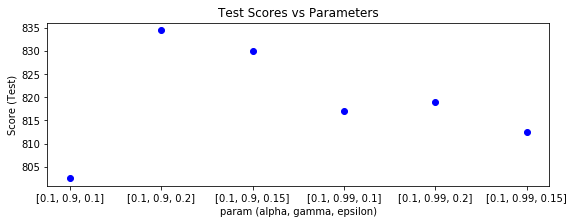

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,3))
for elem in param_score_agent_rewards_steps_list:
    param = str(elem[0])
    score = elem[1]
#     agent = elem[2]
#     rewards = elem[3]
#     steps = elem[4]
    plt.plot(param, score, 'ob')
    plt.ylabel('Score (Test)')
    plt.xlabel('param (alpha, gamma, epsilon)')
    plt.title(str('Test Scores vs Parameters'))

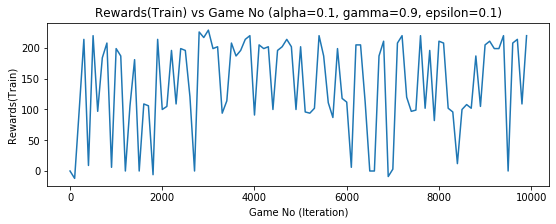

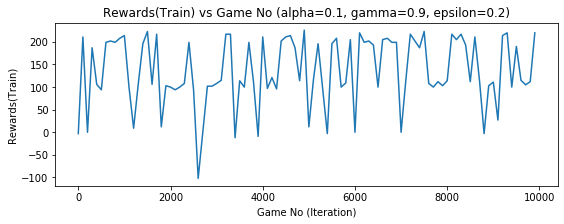

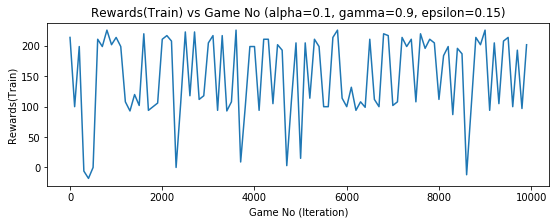

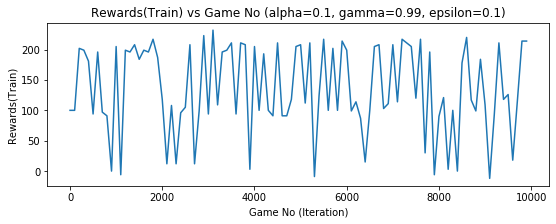

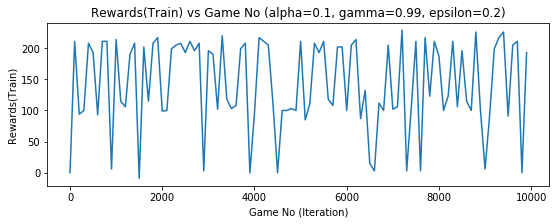

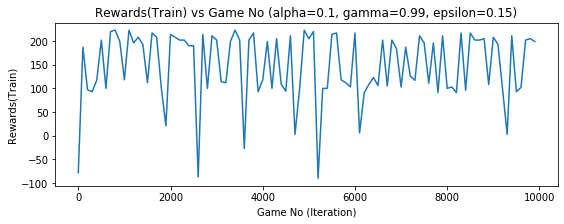

In [62]:
for elem in param_score_agent_rewards_steps_list:
    fig = plt.figure(figsize=(9,3))
    param = elem[0]
    rewards = elem[3]
    l= list(range(10000))
    x= l[0:10000:100]
    y = rewards[0:10000:100]
    plt.plot( x, y, '-'   )
    plt.ylabel('Rewards(Train)')
    plt.xlabel('Game No (Iteration)')
    plt.title( str('Rewards(Train) vs Game No (alpha=%s, gamma=%s, epsilon=%s)'%(param[0], param[1], param[2]) ) )

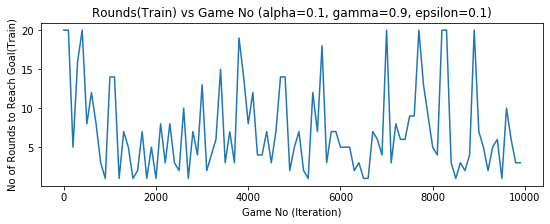

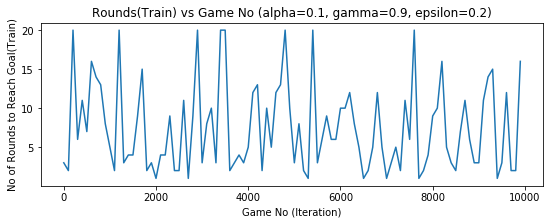

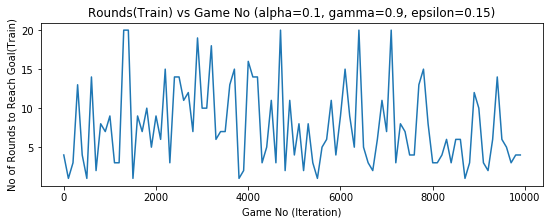

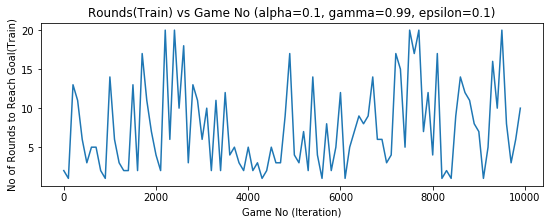

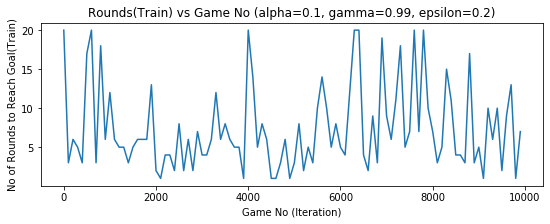

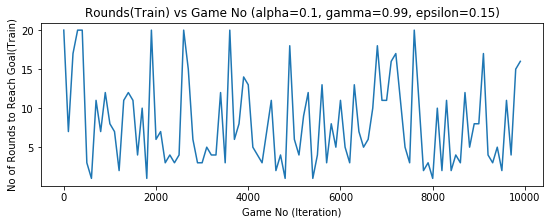

In [63]:
for elem in param_score_agent_rewards_steps_list:
    fig = plt.figure(figsize=(9,3))
    param = elem[0]
    rounds = elem[4]
    l= list(range(10000))
    x= l[0:10000:100]
    y = rounds[0:10000:100]
    plt.plot( x, y, '-'   )
    plt.ylabel('No of Rounds to Reach Goal(Train)')
    plt.xlabel('Game No (Iteration)')
    plt.title( str('Rounds(Train) vs Game No (alpha=%s, gamma=%s, epsilon=%s)'%(param[0], param[1], param[2]) ) )

### III.D reading and analysis of learning results and plots
 

# IV - Participation in the tournament

#### TODO

# V. Conclusions

<!-- Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it.  -->

The major challenge that i faced in this assignment is how to define the states and the actions. 

The algorithm and other approaches are not that hard to implement as from the pseudocode,

but without defining the states and the actions properly its quite struggling to go ahead.

Another think i guess important to be careful about the states and actions while updating the Q values.

One thing i find interesting is to define different reward/penalty based on the different outcomes.

It was quite interesting to experiment with different rewards

# Extra Credit for Tournament Top16!

- In two classes, we will have qualification and tournament.
- To participate the tournament, you need to use this [client](http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/StudentClient.ipynb) codes.
- Locally you can run the [server](http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/SERVER.ipynb) to verify your run. 

### Qualification Round 

- In qualification game, individual will play against a fixed policy agent on the server
  - You can access the server: TBA
  
  - Highly ranked (by the profit) will proceed to the tournament.
  - max. 32 players will be cut for main tournament (by 11 pm on Dec 1st).
  
### Tournament

- In tournament, 4 players will be play in each round.
  - In a table game, two best scoring players will proceed to next round
  - In final, the game will ends in 50 rounds and winner will be the one with lowest balance. 

## Grading
<!-- 
We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 
 -->
points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
35 | Methods | 
 |10| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 | 5| Choice of Function Approximation and Reason
 |10| Implementation of the selected approach (RLAgent)
 | 5| explanation of the codes
45 | Results 
 |10| Reports the selected parameters 
 |15| Experimental outputs that show the choice of parameters. How do you choose them?
 |10| Output plots (5 for each)
 |10| reading and analysis of learning results and plots
10 | Participation to the tournament.
5 | Conclusions 
